<a href="https://colab.research.google.com/github/stepsbtw/Machine-Learning/blob/main/notebooks/shap_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Values (SHapley Additive exPlanations)
É um método para explicar as saídas de um modelo de aprendizado de máquina.

Baseado nos **Shapley Values** da teoria dos jogos cooperativa.

- Distribuir a predição do modelo ("payout") de maneira justa pelas features ("players")

Calcular a **contribuição marginal** ao longo de todas as combinações de features possíveis ("coalitions")

## Passo a Passo
1. Escolher um **background dataset** $D ⊆ ℝ^n$ (uma sample dos dados de treino).
2. Modelo $h(x) : ℝ^n→ℝ$ e uma instancia $x ∈ ℝ^n$ para explicar.
3. Computar o valor **SHAP baseline** (referencia) $\phi_0$.
4. Para cada feature, computar a **média ponderada das contribuições marginais** $\phi_i$.

### 1) Escolher um Background Dataset

Selecione o dataset $D$ que representa a distribuição das features.
- Esse dataset vai ser usada para simular o que o modelo iria predizer se algumas features estivessem "Faltando"
- Tipicamente é um subconjunto dos dados de treino.
- Notação: $D = \{x^{(1)}, x^{(2)}, ⋯, x^{(m)}\}$

### 2) Modelo e Instância

- Seja $h : ℝ^n → ℝ$ a **função preditora** (hipótese)
- Seja $x = (x_1, x_2, ⋯, x_n)$ a instância que a saída $h(x)$ queremos explicar.

### 3) Valor SHAP Baseline $\phi_0$

$$
\phi_0 = \mathbb{E}_{x'∼D}[h(x')]
$$

$\phi_0$ é o valor esperado que o modelo daria de saída em um background dataset $D$.

- Representa a predição do modelo quando **não se conhece nenhuma feature**.
- Todos os valores SHAP são computados relativos a este baseline.

Um modelo não pode realmente produzir uma predição sem features.

- Mas o SHAP aproxima qual seria a saída do modelo nessa situação, computando a predição esperada no background dataset.

**O que o $x'$ significa ?**

- $x'$ é uma única instância (uma linha) de $D$
- $D$ é tipicamente um subconjunto de treino e é usado para simular o que o modelo prediz sem features.
- A notação $\mathbb{E}_{x'∼D}$ significa a predição média sobre todos os $x' \in D$

Portanto, na prática:

$$
\phi_0 = \frac{1}{|D|}∑_{x'∈D}h(x')
$$

Exemplo:

$$
D = {(0,0), (0,1), (1,0), (1,1)}
\\\phi_0 = \frac{1}{4}[h(0,0) + h(0,1) + h(1,0) + h(1,1)]
$$



# O que são os valores SHAP?

Uma técnica de **interpretação** de modelos baseada na teoria dos jogos (cooperativa).

Medem **quanto cada feature** contribui para a **previsão** do modelo. Pra isso, avaliam todas as **combinações possíveis de variáveis** com e sem uma feature específica para determinar sua **importância marginal média**.

Cada feature é um jogador, o pagamento é a predição do modelo, SHAP diz quanto cada jogador contribuiu em média para o resultado do jogo, considerando todas as combinações possíveis.

## Útil para:

- **Entender predições individuais**: Valores SHAP ajudam explicar como cada feature contribuiu a decisão do modelo.

- **Visualizar Explicação para Instâncias Específicas**: Particularmente útil para analisar o comportamento do modelo em pontos de dados específicos, por que o modelo tomou aquela decisão.
  - **Summary plots**, **Dependence plots**, **Force plots**

A biblioteca `SHAP` possui varios plots para entendermos as predições.

## Definições

1. **Odds Ratio**: **Proporção das chances**, proporção entre a probabilidade de um evento acontecer e a de não acontecer.
  - No classificador binário, p/(1-p).

2. **Log Odds**: O logarítmo natural da odds ratio, bom para transformar a escala simétrica em torno de zero.

# Demonstração 1) Renda de Adultos Dataset

Vamos visualizar a importancia das features e interpretar predições individuais.

Nesse dataset, queremos criar um modelo de ML para a seguinte **classificação binária**:

Predizer se um indivíduo ganha mais ou menos de $50,000 por ano baseado em algumas features sobre ele.

- Age : in years
- Workclass : Tipo de emprego
- fnlwgt : Final Weight, quantas unidades na população objetivo essa linha representa.
- Education : O maior nível de educação alcançado.
- Education-Num : Representação numérica do nível de educação.
- Marital Status : Estado civil do indivíduo
- Ocupação : Tipo de ocupação
- Relacionamento : Estado de relacionamento
- Race : Etinia
- Sex : Gênero
- Capital Gain : Ganhos registrados
- Capital Loss : Perdas registradas
- Hours per week : Horas de trabalho por semana
- Country : País de origem
- Target : Variável objetivo indicando caso o indivíduo ganha mais de 50K.

Digamos que, gostariamos de entender por que o modelo predisse que certos individuos ganham mais de 50,000.

- Escolha um subset das instâncias de teste
- Compute os valores SHAP para estas instâncias, assim podemos entender a contribuição de cada feature para cada instância.
- Os valores SHAP podem ser visualizados com SHAP plots.

In [15]:
import shap
raw_data, target = shap.datasets.adult(display=True)

raw_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [18]:
print(raw_data.Relationship.unique(), "\n")
print(raw_data.Workclass.unique(), "\n")
print(raw_data.Race.unique(), "\n")
print(raw_data.Country.unique(), "\n")

[' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried', ' Other-relative']
Categories (6, object): [' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
                         ' Unmarried', ' Wife'] 

[' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked']
Categories (9, object): [' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ...,
                         ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'] 

[' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other']
Categories (5, object): [' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'] 

[' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ..., ' Vietnam', ' Hong', ' Ireland', ' Hungary', ' Holand-Netherlands']
Length: 42
Categories (42, object): [' ?', ' Cambodia', ' Canada', ' China', ..., ' Trinadad&Tobago',
                          ' United-States', ' Vietna

<Axes: >

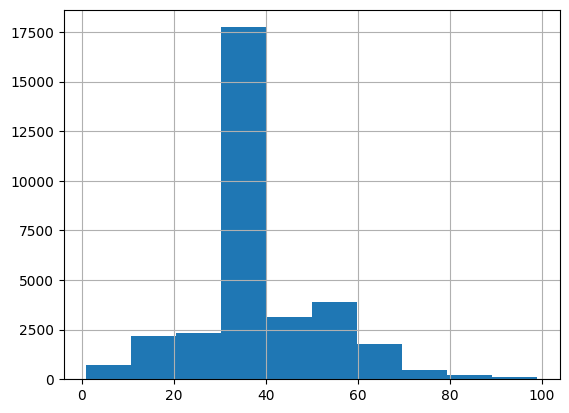

In [19]:
raw_data['Hours per week'].hist()

Vamos antes de qualquer coisa, preprocessar os dados:

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32561 non-null  float32
 1   Workclass       32561 non-null  int8   
 2   Education-Num   32561 non-null  float32
 3   Marital Status  32561 non-null  int8   
 4   Occupation      32561 non-null  int8   
 5   Relationship    32561 non-null  int64  
 6   Race            32561 non-null  int8   
 7   Sex             32561 non-null  int8   
 8   Capital Gain    32561 non-null  float32
 9   Capital Loss    32561 non-null  float32
 10  Hours per week  32561 non-null  float32
 11  Country         32561 non-null  int8   
dtypes: float32(5), int64(1), int8(6)
memory usage: 1.1 MB


In [25]:
y

array([False, False, False, ..., False, False,  True])

Note como a variável target está (0,1)

In [26]:
y[y==0].shape, y[y==1].shape

((24720,), (7841,))

## Vamos treinar o modelo

In [27]:
import xgboost as xgb
import pandas as pd

model = xgb.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)

model.fit(X_train, y_train)

print(f"Model Accuracy: {model.score(X_test, y_test):.2f}")

Model Accuracy: 0.87


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:36:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Usar SHAP
Entender as saídas de nosso modelo RandomForest.

In [28]:
import shap

num_samples = 3000

# inicializar o explainer
explainer = shap.TreeExplainer(model)

# calcular os valores shap
shap_values = explainer.shap_values(X_test[0:num_samples])

## Plot Sumário
Uma visualização compacta que mostra o quanto features contribuem para as predições de um modelo ao longo do dataset inteiro. Combina informações de:
- Importância de features
- Direção de impacto (positiva ou negativa)
- Feature value distribution

### 1. Importância de Feature (Ordem vertical)
- Features listadas de cima para baixo.
- A feature do topo é a mais importante. Possue o **maior shap value médio**.
- Importancia é computada em todas as amostras do dataset.

### 2. Impacto na saída do Modelo (Eixo horizontal)
- O eixo-x representa o SHAP para cada feature em cada exemplo.
- Um SHAP **zero** representa que a feature não teve impacto.
- Um SHAP positivo indica que a feature aumentou o valor da predição.
- Um SHAP negativo indica que a feature diminuiu o valor da predição.

### 3. Cores codificam o valor de Feature
- Cada ponto representa uma instância de dados para aquela feature.
- Valores altos são vermelhos.
- Valores baixos são azuis.
- Como os valores das feature se relacionam ao seu efeito:
  - Se valores vermelho estão na direita - valores altas daquela feature aumentam a predição.
  - Se valores vermelho estão à esquerda - valores baixos daquela feature aumentam a predição.



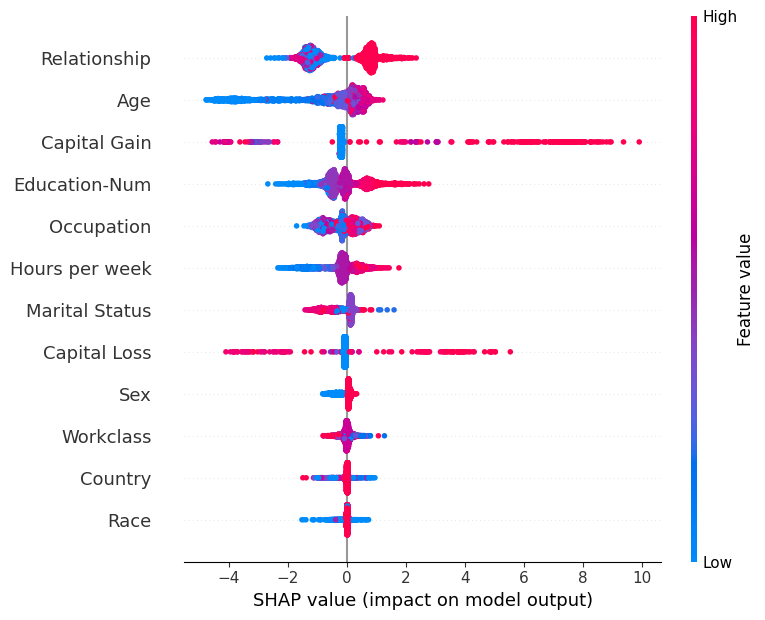

In [29]:
shap.summary_plot(shap_values, X_test[0:num_samples])

`explainer = shap.TreeExplainer(model)` -> usado para explicar modelos de arvore.

Possui uma otimização específica do explicador para modelos Tree-Based.

`shap_values[1]` ou `shap_values[0]` -> valores shap para cada classe.

## Plot de Dependência
Mostra os relacionamentos dos valores das features e o seu SHAP value. Mostra como mudanças na feature impactam na predição do modelo.

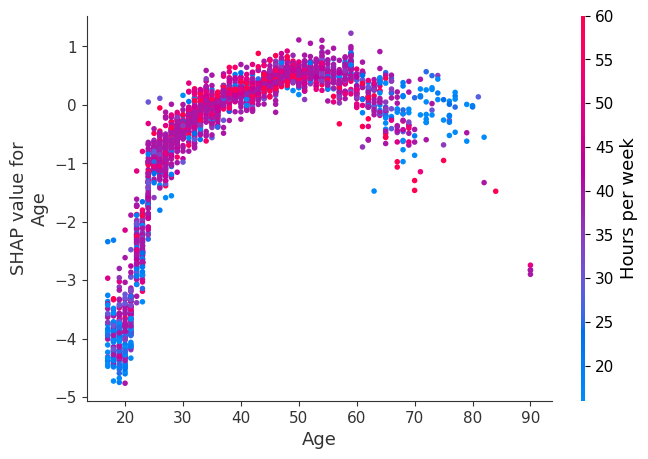

In [32]:
# para uma feature específica!
shap.dependence_plot("Age",
                        shap_values, X_test[0:num_samples],
                        interaction_index='Hours per week')

## Force Plot
Útil para visualizar como diferentes features contribuem à **uma única predição**. (push and pull)

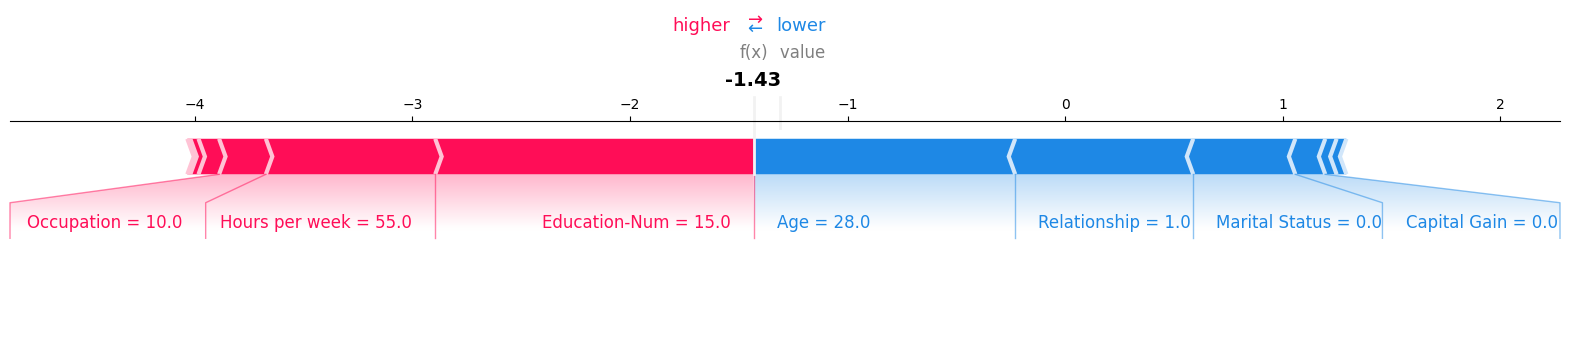

In [33]:
# arbitrario (classe 1)
sample_idx = 10
shap.force_plot(explainer.expected_value,
                shap_values[sample_idx],
                X_test.iloc[sample_idx],
                matplotlib=True)

`explainer.expected_value[1]` -> representa o **baseline**, o **valor esperado** para a classe explicada.

`shap_values[1][0]` array de valores SHAP para a primeira instancia do X_test (todas features)

`force_plot()` -> contribuicao positiva: aumentam o valor da predição, a magnitude é o tamanho da barra.

# Demonstração 2) Housing Dataset


- **MedInc**: median income in block group
- **HouseAge**: median house age in block group
- **AveRooms**: average number of rooms per household
- **AveBedrms**: average number of bedrooms per household
- **Population**: block group population
- **AveOccup**: average number of household members
- **Latitude**: block group latitude
- **Longitude**: block group longitude


In [34]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load the California housing dataset
california = fetch_california_housing(as_frame=True)
X = california.data
y = california.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Generating SHAP values can be time-consuming. Here, we use only a subset of the test dataset.
num_samples = 200

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test[0:num_samples])

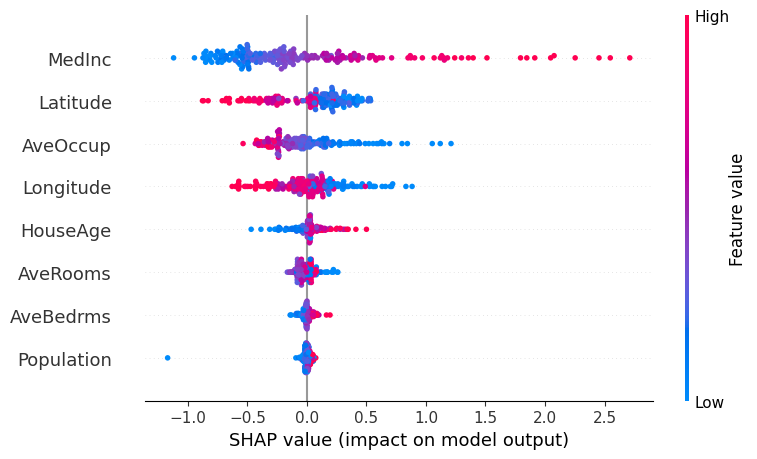

In [36]:
shap.summary_plot(shap_values, X_test[0:num_samples])

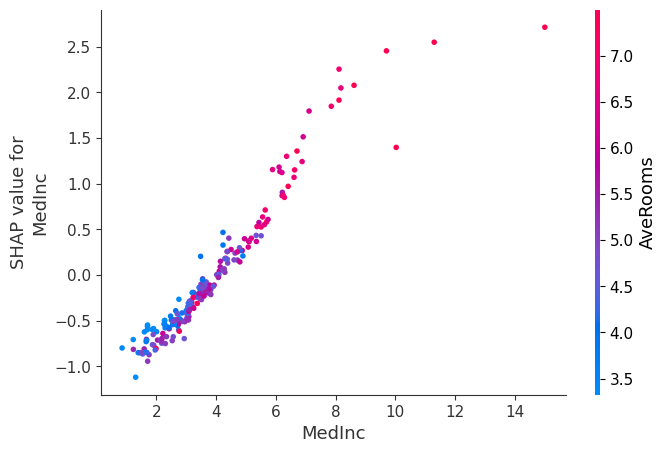

In [37]:
# Dependence plot for the feature 'MedInc' (Median Income)
shap.dependence_plot('MedInc', shap_values, X_test[0:num_samples])

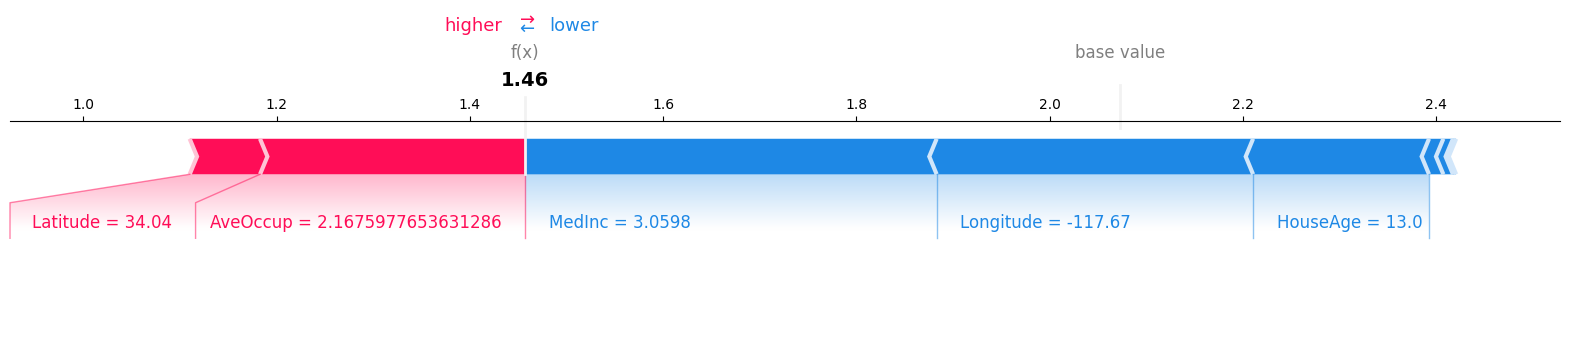

In [38]:
# Force plot for the instance with index 100 in the test set
sample_idx = 100
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test.iloc[sample_idx], matplotlib=True)

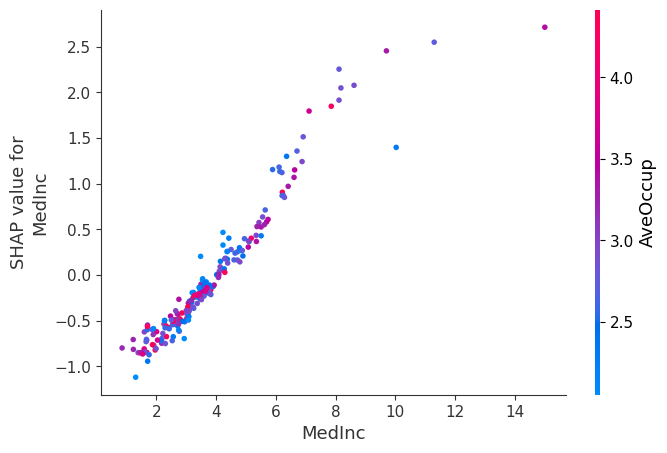

In [39]:
# Interaction plot between 'MedInc' and 'AveOccup' (Average Occupancy)
shap.dependence_plot('MedInc', shap_values, X_test[0:num_samples], interaction_index='AveOccup')

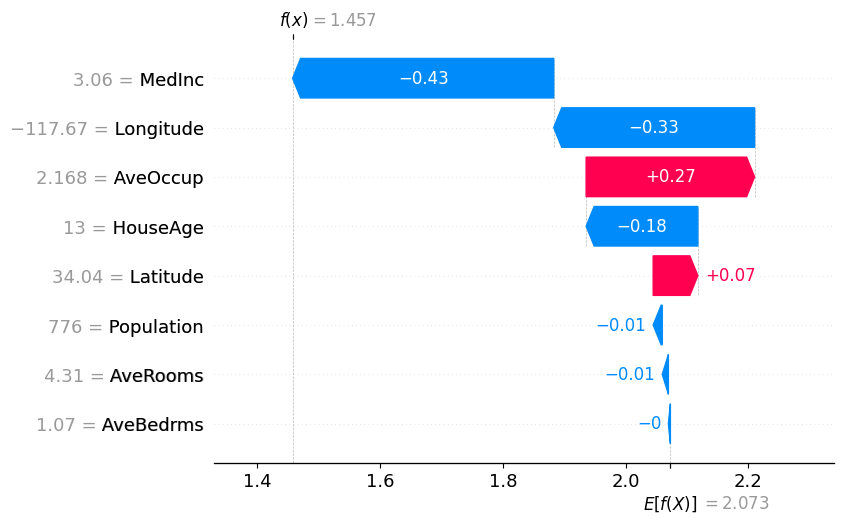

In [40]:
# Waterfall plot for instance with index 100 in the test set
sample_idx = 100
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx],
                                     base_values=explainer.expected_value,
                                     data=X_test.iloc[sample_idx]))